## 2.4 in Assignment 2 - DD2434 Machine Learning, Advanced
### Author: Hannes Kindbom

In [1]:
import numpy as np
from scipy.stats import norm, gamma, multivariate_normal
from itertools import product
import matplotlib.pyplot as plt

### Generate synthetic dataset

In [70]:
np.random.seed(1338)
N = 30 # number of samples
mu = 0.2
tau = 0.5 #precision

X_range = np.linspace(0, 1.0, num=N)
X = np.random.normal(mu, 1/tau**0.5, N)
X_mean = np.mean(X)

In [40]:
#Assuming prior P(mu|tau) to be N(mu_0, (lambda_0*tau)⁻1)
# and prior p(tau) to be Gamma(a_0, b_0)

#help functions
def get_mu_N(X_mean, N):
    mu_N = (lambda_0*mu_0 + N*X_mean)/(lambda_0 + N)
    return mu_N

def get_lambda_N(E_tau, N):
    lambda_N = (lambda_0 + N)*E_tau
    return lambda_N

def get_a_N(N):
    a_N = a_0 + N/2
    return a_N

def get_b_N(X, E_mu, Var_mu):
    b_N = b_0 + 0.5*get_E_mu_expression(X, E_mu, Var_mu)
    return b_N

def get_E_mu_expression(X, E_mu, Var_mu):
    E_mu_2 = Var_mu + E_mu**2
    term1 = np.power(X, 2) - 2*X*E_mu + E_mu_2
    summed = np.sum(term1)
    term2 = lambda_0*E_mu_2 - 2*E_mu*mu_0 + mu_0**2
    E_mu_expression = summed + term2
    return E_mu_expression

### Iteratively compute variational distribution

In [43]:
#Prior parameters
lambda_0 = 1
mu_0 = 0
a_0 = 1
b_0 = 1

In [42]:
def re_estimate_param(iterations, E_tau_guess):

    #initial guess
    E_tau = E_tau_guess

    for i in range(iterations):
        mu_N = get_mu_N(X_mean, N)
        lambda_N = get_lambda_N(E_tau, N)

        a_N = get_a_N(N)
        b_N = get_b_N(X, mu_N, 1/lambda_N)

        #re-estimate
        E_tau = a_N/b_N
        
    return lambda_N, mu_N, a_N, b_N
    

### Visualizing the result

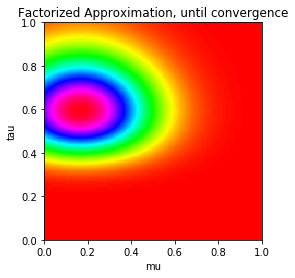

In [71]:
pixels = 200
#q_mu is gaussian and q_tau is gamma(a,b)
q_mu_prec, q_mu_mean, q_tau_a, q_tau_b = re_estimate_param(iterations = 10, E_tau_guess = 1)

mu_range = np.linspace(0, 1.0, num=pixels)
tau_range = np.linspace(0, 1.0, num=pixels)

X, Y = np.meshgrid(tau_range, mu_range)
N, M = len(X), len(Y)
Z = np.zeros((N, M))
for i,(x,y) in enumerate(product(tau_range,mu_range)):
    pos = np.hstack((x, y))
    tau = pos[0]
    mu = pos[1]
    Z[np.unravel_index(i, (N,M))] =  norm(q_mu_mean, 1/q_mu_prec**0.5).pdf(mu)*gamma.pdf(tau, q_tau_a, scale=1/q_tau_b)
    
im = plt.imshow(Z,cmap='hsv', origin='lower', extent=(0, 1, 0, 1)) #extent = (left, right, bottom, top)
ax = plt.gca()
ax.grid(False)
plt.title("Factorized Approximation, until convergence")
plt.xlabel('mu')
plt.ylabel('tau')
plt.show()

### Comparing with exact posterior

/home/hannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


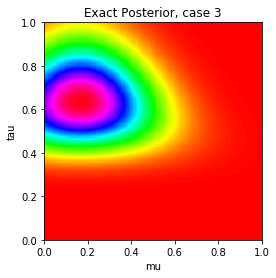

In [65]:
post_mu = (lambda_0*mu_0 + N*X_mean)/(lambda_0 + N)
post_lambda = lambda_0 + N
post_a = a_0 + N/2
post_b = b_0 + 0.5*np.sum(np.power(X - X_mean, 2)) + (lambda_0*N*(X_mean - mu_0)**2)/(2*(lambda_0 + N))

post_mu_range = np.linspace(0, 1.0, num=pixels)
post_tau_range = np.linspace(0, 1.0, num=pixels)

X_post, Y_post = np.meshgrid(post_tau_range, post_mu_range)
post_N, post_M = len(X_post), len(Y_post)
Z_post = np.zeros((post_N, post_M))
for i,(x,y) in enumerate(product(post_tau_range,post_mu_range)):
    pos = np.hstack((x, y))
    tau = pos[0]
    mu = pos[1]
    tau_sample = gamma.pdf(tau, post_a, scale=1/post_b)
    Z_post[np.unravel_index(i, (post_N,post_M))] =  norm(post_mu, 1/(post_lambda*tau)**0.5).pdf(mu)*tau_sample
    
im = plt.imshow(Z_post,cmap='hsv', origin='lower', extent=(0, 1, 0, 1))
ax = plt.gca()
ax.grid(False)
plt.title("Exact Posterior, case 3")
plt.xlabel('mu')
plt.ylabel('tau')
plt.show()